Show the origin of the steel in UK final goods:
1. Imported in final goods
2. Imported in components
3. Imported in semi-finished products
4. UK produced steel

In [1]:
import pandas as pd
flows = pd.read_csv('../data/flows.csv')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

In [3]:
sectors = ['4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15a', '15b', '16', '17', '18', '19', '20']

sector_names = [
    'Fasteners',
    'Hand tools, cutlery, instruments',
    'Packaging, industrial/domestic hollow-ware',
    'Other metal goods',
    'Electrical engineering, incl. appliances',
    'Agricultural machinery',
    'Metal working tools & engineering tools',
    'Construction, earth moving & handling equipment',
    'Other mechanical engineering',
    'Industrial & process plant',
    'Construction & fabricated steelwork',
    'Motor vehicles: BIW',
    'Motor vehicles: drivetrain, chassis, trimmings',
    'Other transport',
    'Coal, coke, petroleum & natural gas',
    'Gas, electricity & water',
    'Chemical & allied industries',
    'Other UK consumers'
]

sector_groups = [
    ('Metal goods', ['4', '5', '6', '7']),
    ('Elec. eng', ['8']),
    ('Mech. eng', ['9', '10', '11', '12', '13']),
    ('Construction', ['14']),
    ('Transport', ['15a', '15b', '16']),
    ('Energy/water', ['17', '18', '19']),
    ('Other', ['20']),
]

In [4]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

Work backwards. For each type of final goods, this is how much is imported directly:

In [5]:
imported_final = flows.query('source == "product_imports"').groupby(['year', 'material'])['value'].sum()
#imported_final

And this is how much comes from UK manufacturing:

In [6]:
uk_manufac = flows.query('target == "uk_demand" and source != "product_imports"') \
    .groupby(['year', 'material'])['value'].sum()
#uk_manufac

The origin of the UK manufacturing is assumed to be proportional to the part exported (final goods) and the part delivered to the UK.

In [7]:
sector_ids = ['sector %s' % s for s in sectors]
inputs = flows.query('target in @sector_ids').copy()
inputs['target'] = inputs['target'].str.lstrip('sector ')
inputs = inputs.groupby(['year', 'target', 'source'])['value'].sum().unstack()
inputs.index.names = ['year', 'material']

# Collect results together
scale = (uk_manufac / inputs.sum(axis=1))
results = pd.DataFrame({
    'UK produced steel':       scale * inputs['uk_production'],
    'Imported as semis':       scale * inputs['imports'],
    'Imported as components':  scale * inputs['component_imports'],
    'Imported as final goods': imported_final,
}).fillna(0) / 1e3

results = results.reindex(sectors[::-1], level='material')

Summarise the results across all products:

In [8]:
results.loc[2016].sum()

UK produced steel          2.722735
Imported as semis          3.565814
Imported as components     0.592552
Imported as final goods    6.942100
dtype: float64

In [9]:
results.loc[2016].sum().sum()

13.8232

Percentages by origin:

In [10]:
(results.loc[2016].sum() / results.loc[2016].sum().sum() * 100).round(1)

UK produced steel          19.7
Imported as semis          25.8
Imported as components      4.3
Imported as final goods    50.2
dtype: float64

Plot these results:

In [11]:
from palettable.colorbrewer import qualitative as cbq
colors = ['black'] + cbq.Set3_7.hex_colors[4:]

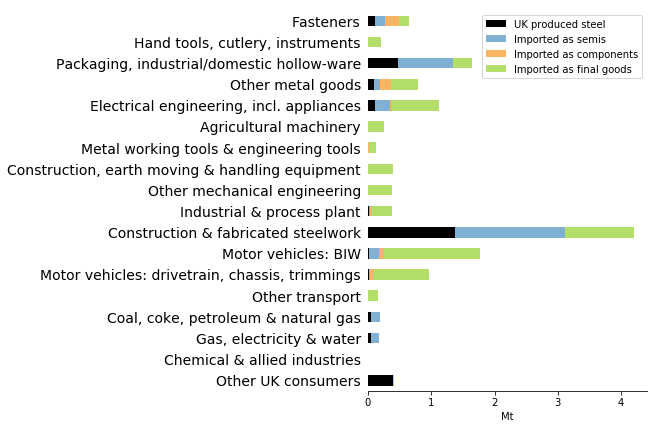

In [12]:
fig, ax = plt.subplots(figsize=(5, 7))
results.loc[2016].plot.barh(stacked=True, color=colors, ax=ax)
ax.yaxis.set_ticks_position('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_xticks([0, 1, 2, 3, 4])
ax.set_yticklabels(labels=sector_names[::-1], fontsize=14);
plt.xlabel('Mt')
plt.ylabel('');

fig.savefig('../figures/uk_final_goods_origin_leftaligned.pdf', bbox_inches='tight')

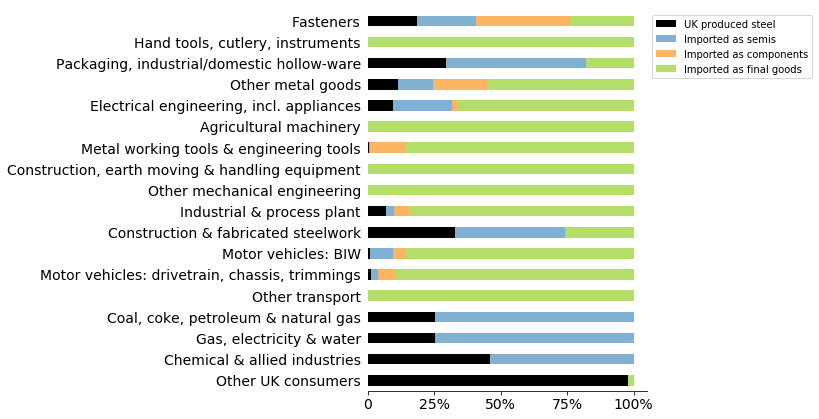

In [13]:
proportions = results.copy()
for c in proportions.columns:
    proportions[c] /= results.sum(axis=1)

fig, ax = plt.subplots(figsize=(5, 7))
proportions.loc[2016].plot.barh(stacked=True, color=colors, ax=ax)
ax.yaxis.set_ticks_position('none')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.set_yticklabels(labels=sector_names[::-1], fontsize=14);
ax.set_xticks([0, 0.25, 0.5, 0.75, 1])
ax.set_xticklabels(['0', '25%', '50%', '75%', '100%'], fontsize=14);
ax.legend(bbox_to_anchor=(1, 1))
plt.xlabel('')
plt.ylabel('');

fig.savefig('../figures/uk_final_goods_origin_proportions.pdf', bbox_inches='tight')

Try showing UK production on the LHS?

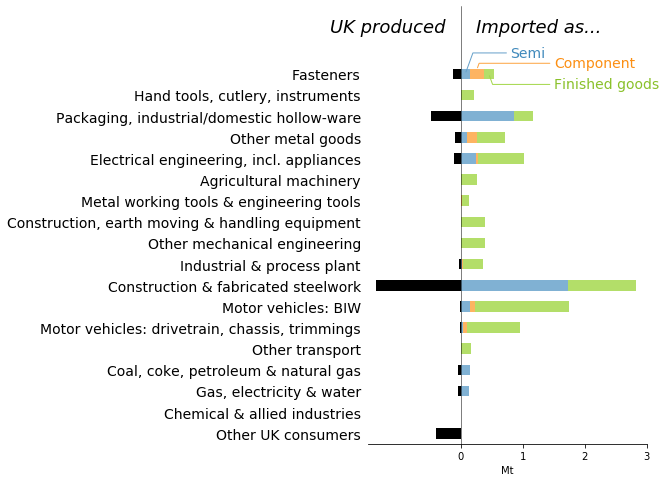

In [14]:
df = results.copy()
df['UK produced steel'] *= -1

import numpy as np
def plot_origin(year):
    fig, ax = plt.subplots(figsize=(5, 7))
    df.loc[year].plot.barh(stacked=True, ax=ax, color=colors, legend=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.yaxis.set_ticks_position('none')
    ax.axvline(0, ymax=1.15, color='k', lw=0.5, clip_on=False)
    ax.set_yticklabels(sector_names[::-1], fontsize=14);
    ax.set_xticks([0, 1, 2, 3])
    ax.set_xlim(-1.5, 3)
    ax.set_xlabel('Mt')
    ax.set_ylabel('');
    ax.text(-0.25, 19, 'UK produced', fontsize=18, fontstyle='italic', ha='right')
    ax.text( 0.25, 19, 'Imported as...', fontsize=18, fontstyle='italic', ha='left')

    def annot(text, xy, xytext, color, **kwargs):
        ab = 70 if xytext[1] > xy[1] else 110
        ax.annotate(text, xy, xytext, annotation_clip=False, color=lighten_color(color, 1.5), fontsize=14,
                    arrowprops=dict(arrowstyle='-', color=lighten_color(color, 1.2),
                                    connectionstyle="angle,angleA=0,angleB=%d,rad=0" % ab), **kwargs)

    edges = np.r_[0, df.loc[(year, '4')].iloc[1:].cumsum()]
    midpoints = (edges[0:-1] + edges[1:]) / 2

    annot('Semi', (midpoints[0], 17), (0.8, 17.8), colors[1])
    annot('Component', (midpoints[1], 17.2), (1.5, 17.5), colors[2], ha='left', va='center')
    annot('Finished goods', (midpoints[2], 17.0), (1.5, 16.5), colors[3], ha='left', va='center')
    return fig, ax

fig, ax = plot_origin(2016)
#fig.savefig('../figures/uk_final_goods_origin.pdf', bbox_inches='tight')

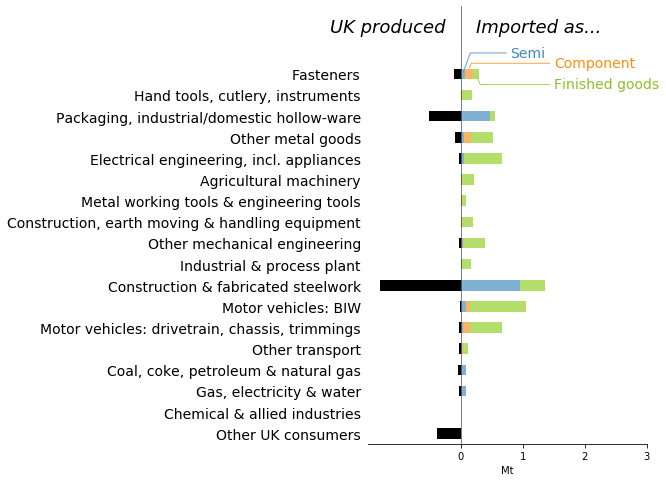

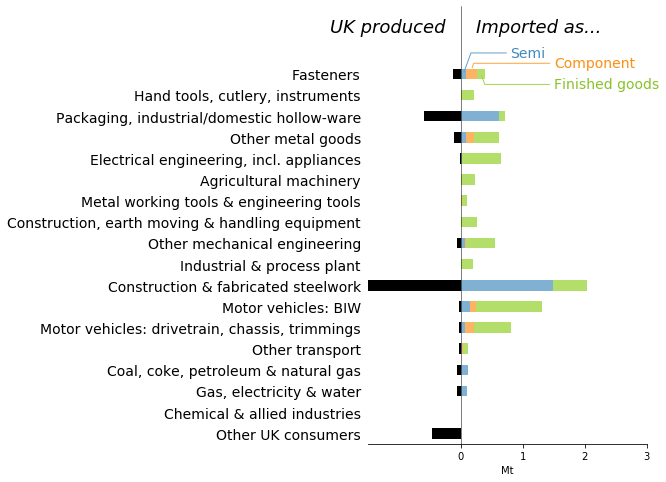

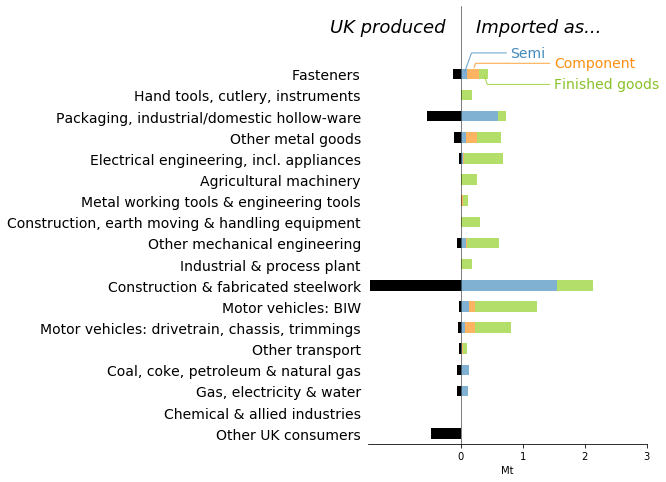

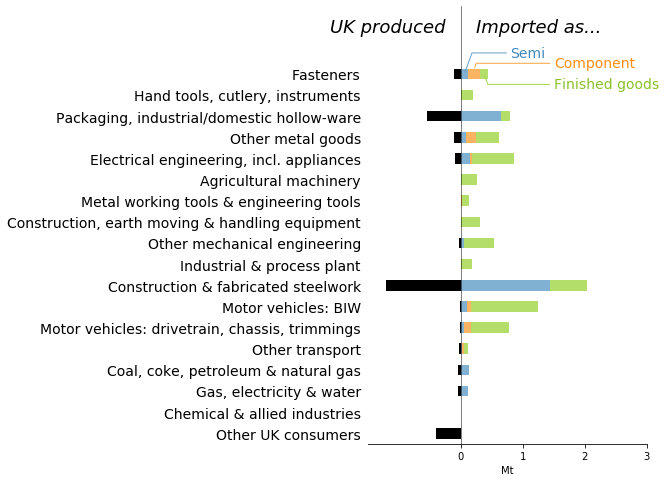

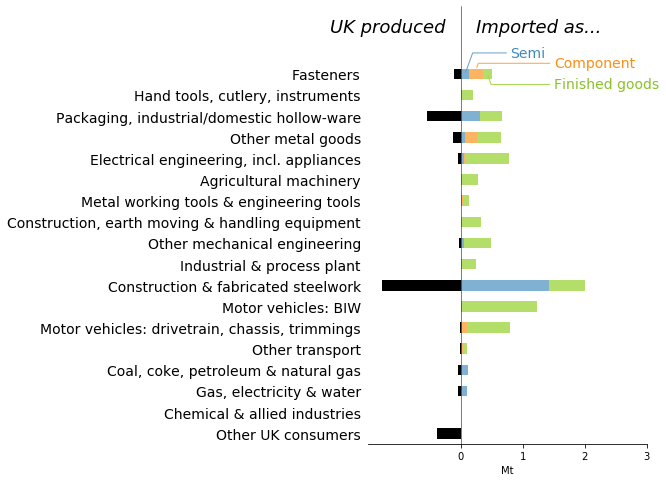

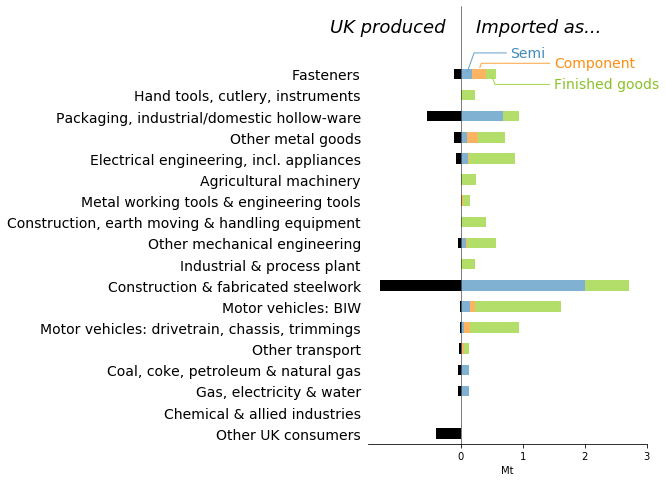

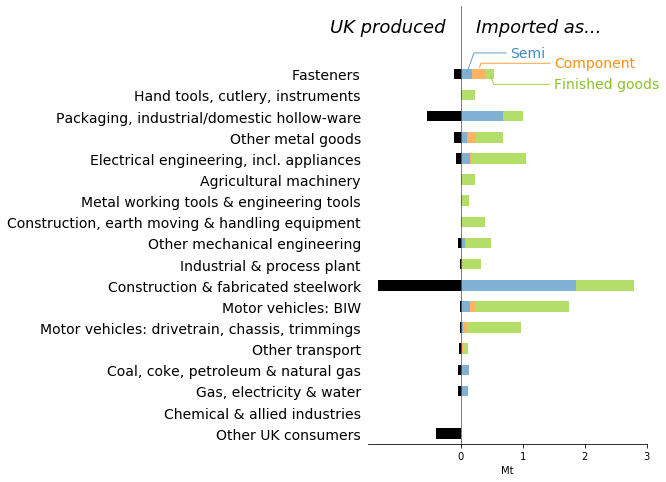

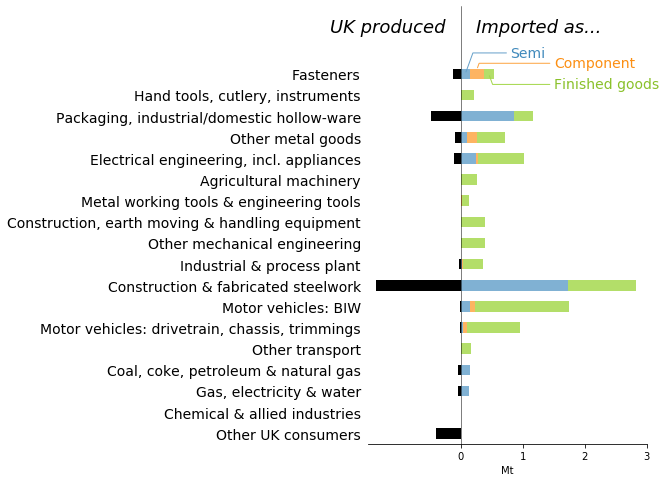

In [15]:
for year in range(2009, 2017):
    fig, ax = plot_origin(year)
    fig.savefig('../figures/uk_final_goods_origin_%s.pdf' % year, bbox_inches='tight')